/home/cogu/.conda/envs/bert-try/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda
Number of GPUs available: 1
GPU 0: NVIDIA A100 80GB PCIe
  Memory Allocated: 0.00 GB
  Memory Cached: 0.00 GB
O: 25000
B-CHAR: 820
I-CHAR: 85
B-LOC: 216
B-ORG: 2
I-LOC: 2
labels_to_ids: {'I-LOC': 0, 'B-CHAR': 1, 'I-CHAR': 2, 'B-ORG': 3, 'B-LOC': 4, 'O': 5}
ids_to_labels: {0: 'I-LOC', 1: 'B-CHAR', 2: 'I-CHAR', 3: 'B-ORG', 4: 'B-LOC', 5: 'O'}
Initial tag counts in test_tags: {'O': 25000, 'B-CHAR': 820, 'I-CHAR': 85, 'B-LOC': 216, 'B-ORG': 2, 'I-LOC': 2}


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training with subset size: 1
Epoch 1/5, Train Loss: 1.5776607990264893
Epoch 2/5, Train Loss: 1.1286735534667969
Epoch 3/5, Train Loss: 0.7092359662055969
Epoch 4/5, Train Loss: 0.4514499008655548
Epoch 5/5, Train Loss: 0.3024325668811798
Validation loss per 100 evaluation steps: 0.9236751198768616
Validation Loss: 0.8893450485335456
Validation Accuracy: 0.9479808612440191
F1 Score: 0.010852713178294573
{'CHAR': {'precision': 0.03414634146341464, 'recall': 0.00853658536585366, 'f1-score': 0.013658536585365854, 'support': 820}, 'LOC': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 216}, 'ORG': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 2}, 'micro avg': {'precision': 0.027777777777777776, 'recall': 0.00674373795761079, 'f1-score': 0.010852713178294573, 'support': 1038}, 'macro avg': {'precision': 0.011382113821138212, 'recall': 0.002845528455284553, 'f1-score': 0.0045528455284552845, 'support': 1038}, 'weighted avg': {'precision': 0.026974951830443163, '

/home/cogu/.local/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'CHAR': {'precision': 0.6931818181818182, 'recall': 0.07439024390243902, 'f1-score': 0.1343612334801762, 'support': 820}, 'LOC': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 216}, 'ORG': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 2}, 'micro avg': {'precision': 0.6931818181818182, 'recall': 0.05876685934489403, 'f1-score': 0.108348134991119, 'support': 1038}, 'macro avg': {'precision': 0.23106060606060608, 'recall': 0.024796747967479674, 'f1-score': 0.0447870778267254, 'support': 1038}, 'weighted avg': {'precision': 0.5476002802592399, 'recall': 0.05876685934489403, 'f1-score': 0.10614278560090991, 'support': 1038}}
Eval Loss: 0.4789588941468133, Eval Accuracy: 0.958354066985646
{'CHAR': {'precision': 0.6931818181818182, 'recall': 0.07439024390243902, 'f1-score': 0.1343612334801762, 'support': 820}, 'LOC': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 216}, 'ORG': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 2}, 'micr

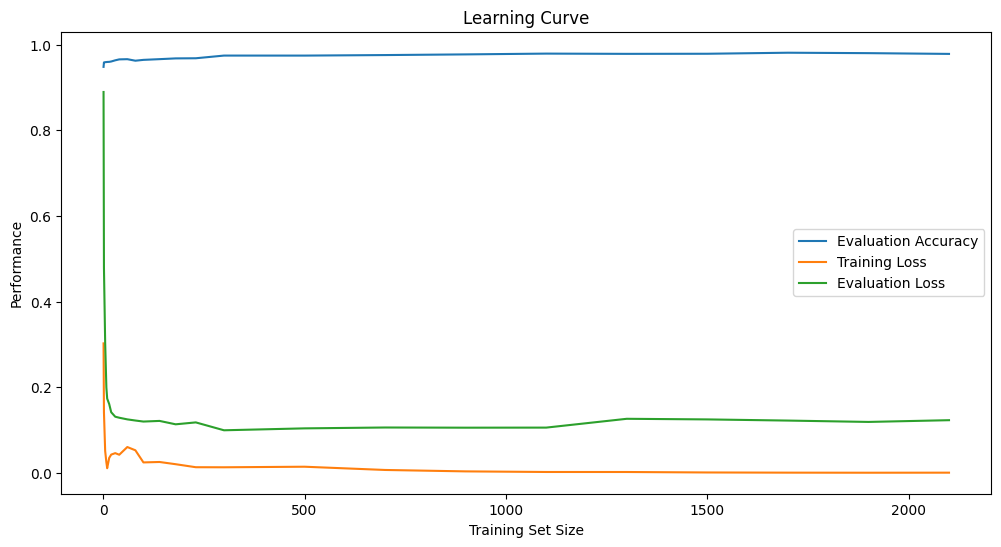

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from transformers import BertTokenizerFast, BertForTokenClassification
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from seqeval.metrics import f1_score, accuracy_score
from seqeval.metrics import classification_report as seqeval_classification_report    
from collections import defaultdict


MAX_LEN = 174
BATCH_SIZE = 64
EPOCHS = 5
MAX_GRAD_NORM = 5
MODEL_NAME = 'bert-base-uncased'
MODEL_PATH = 'ner_model_from_final1.pth'
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

# Data Reading and Preprocessing Functions


# Check if CUDA is available
if torch.cuda.is_available():
    # Get the number of GPUs
    num_gpus = torch.cuda.device_count()
    print(f"Number of GPUs available: {num_gpus}")
    
    # Get the name and other details of each GPU
    for i in range(num_gpus):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"  Memory Allocated: {torch.cuda.memory_allocated(i) / 1024**3:.2f} GB")
        print(f"  Memory Cached: {torch.cuda.memory_reserved(i) / 1024**3:.2f} GB")
else:
    print("CUDA is not available. Running on CPU.")

class dataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, index):
        sentence = self.data.sentence[index].strip().split()
        word_labels = self.data.word_labels[index].split(",")

        encoding = self.tokenizer(sentence,
                                  is_split_into_words=True,
                                  return_offsets_mapping=True,
                                  padding='max_length',
                                  truncation=True,
                                  max_length=self.max_len)

        labels = [labels_to_ids[label] for label in word_labels]

        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100
        i = 0
        for idx, mapping in enumerate(encoding["offset_mapping"]):
            if mapping[0] == 0 and mapping[1] != 0:
                encoded_labels[idx] = labels[i]
                i += 1

        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)

        return item

    def __len__(self):
        return self.len

def read_data(file_path):
    sentences, labels = [], []
    sentence, label = [], []
    with open(file_path, encoding="utf-8") as file:
        for line in file:
            if line.startswith("#"):
                continue
            elif line == "\n":
                if sentence:
                    sentences.append(sentence)
                    labels.append(label)
                    sentence, label = [], []
            else:
                parts = line.strip().split("\t")
                sentence.append(parts[1].lower())  # Convert the token to lowercase before appending
                label.append(clean_tag(parts[2]))
    if sentence:
        sentences.append(sentence)
        labels.append(label)
    return sentences, labels

def clean_tag(tag):
    if tag.count('-') > 1:
        prefix, entity = tag.split('-', 1)
        tag = f"{prefix}-{entity.replace('-', '')}"
    return tag

def train_model(training_subset, model, optimizer):
    model.train()
    tr_loss = 0
    nb_tr_steps = 0

    training_loader = DataLoader(training_subset, batch_size=BATCH_SIZE, shuffle=True)
    for idx, batch in enumerate(training_loader):
        ids = batch['input_ids'].to(device, dtype=torch.long)
        mask = batch['attention_mask'].to(device, dtype=torch.long)
        labels = batch['labels'].to(device, dtype=torch.long)

        outputs = model(input_ids=ids, attention_mask=mask, labels=labels)
        loss = outputs.loss
        tr_logits = outputs.logits

        tr_loss += loss.item()
        nb_tr_steps += 1

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=MAX_GRAD_NORM)
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    return epoch_loss

train_tokens, train_tags = read_data("./tagged_sentences_train.iob2")
test_tokens, test_tags = read_data("./tagged_sentences_test.iob2")
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

data = {'sentence': [" ".join(sentence) for sentence in train_tokens],
        'word_labels': [",".join(tags) for tags in train_tags]}

df = pd.DataFrame(data)

data_test = {'sentence': [" ".join(sentence) for sentence in test_tokens],
             'word_labels': [",".join(tags) for tags in test_tags]}

df_test = pd.DataFrame(data_test)



# Initialize a dictionary to hold the counts
tag_counts = defaultdict(int)

# Iterate through each list in test_tags and count the occurrences of each tag
for sentence in test_tags:
    for tag in sentence:
        tag_counts[tag] += 1

# Convert the defaultdict to a regular dictionary for easier printing
tag_counts = dict(tag_counts)

# Print the counts for each tag
for tag, count in tag_counts.items():
    print(f"{tag}: {count}")

# Create mappings
all_tags = [tag for tags in df['word_labels'] for tag in tags.split(",")]
unique_tags = set(all_tags)
labels_to_ids = {k: v for v, k in enumerate(unique_tags)}
ids_to_labels = {v: k for k, v in labels_to_ids.items()}

# Display the mappings
print("labels_to_ids:", labels_to_ids)
print("ids_to_labels:", ids_to_labels)

# Create training and testing datasets
training_set = dataset(df, tokenizer, MAX_LEN)
testing_set = dataset(df_test, tokenizer, MAX_LEN)

test_params = {'batch_size': BATCH_SIZE, 'shuffle': False, 'num_workers': 0}
testing_loader = DataLoader(testing_set, **test_params)

# Function to count tag occurrences
def count_tags(tags_list):
    tag_counts = defaultdict(int)
    for sentence in tags_list:
        for tag in sentence:
            tag_counts[tag] += 1
    return tag_counts

# Count initial tag occurrences in test_tags
initial_tag_counts = count_tags(test_tags)
print("Initial tag counts in test_tags:", dict(initial_tag_counts))

def valid(model, testing_loader):
    # put model in evaluation mode
    model.eval()

    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []

    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            ids = batch['input_ids'].to(device, dtype=torch.long)
            mask = batch['attention_mask'].to(device, dtype=torch.long)
            labels = batch['labels'].to(device, dtype=torch.long)

            # Forward pass
            outputs = model(input_ids=ids, attention_mask=mask, labels=labels)
            loss = outputs.loss
            eval_logits = outputs.logits

            eval_loss += loss.item()
            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)

            if idx % 100 == 0:
                loss_step = eval_loss / nb_eval_steps
                print(f"Validation loss per 100 evaluation steps: {loss_step}")

            # Compute evaluation accuracy
            active_logits = eval_logits.view(-1, model.config.num_labels)  # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1)  # shape (batch_size * seq_len,)

            for i in range(labels.size(0)):
                label = labels[i]
                pred = flattened_predictions.view(labels.size(0), labels.size(1))[i]

                active_accuracy = label != -100  # shape (seq_len,)
                label = torch.masked_select(label, active_accuracy)
                pred = torch.masked_select(pred, active_accuracy)

                eval_labels.append([ids_to_labels[id.item()] for id in label])
                eval_preds.append([ids_to_labels[id.item()] for id in pred])

                tmp_eval_accuracy = accuracy_score(label.cpu().numpy(), pred.cpu().numpy())
                eval_accuracy += tmp_eval_accuracy

    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = accuracy_score(eval_labels, eval_preds)
    F1_score = f1_score(eval_labels, eval_preds)
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")
    print(f"F1 Score: {F1_score}")
    report = seqeval_classification_report(eval_labels, eval_preds, output_dict=True)
    print(report)
    
    return eval_loss, eval_accuracy, F1_score, report

def learning_curve(training_set, testing_loader, model, optimizer, subset_sizes, epochs=5):
    train_losses = []
    eval_losses = []
    eval_accuracies = []
    reports = []
    metrics = []

    for subset_size in subset_sizes:
        print(f"Training with subset size: {subset_size}")
        subset_indices = list(range(subset_size))
        training_subset = Subset(training_set, subset_indices)

        for epoch in range(epochs):
            train_loss = train_model(training_subset, model, optimizer)
            print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss}")

        # Use the valid function for evaluation
        eval_loss, eval_accuracy, f1_score, eval_report = valid(model, testing_loader)
        print(f"Eval Loss: {eval_loss}, Eval Accuracy: {eval_accuracy}")
        print(eval_report)

        train_losses.append(train_loss)
        eval_losses.append(eval_loss)
        eval_accuracies.append(eval_accuracy)
        reports.append(eval_report)

        # Store metrics
        metrics.append({
            "subset_size": subset_size,
            "train_loss": train_loss,
            "eval_loss": eval_loss,
            "accuracy": eval_accuracy,
            "f1_score": f1_score,
            "report": eval_report
        })

    return train_losses, eval_losses, eval_accuracies, reports, metrics


# Define subset sizes and initialize model and optimizer
subset_sizes = [1, 2, 5, 8, 10, 15, 20, 30, 40, 60, 80, 100, 140, 180, 230, 300, 500, 700, 900, 1100, 1300, 1500, 1700, 1900, 2100]
model = BertForTokenClassification.from_pretrained(MODEL_NAME, num_labels=len(labels_to_ids))
model.to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=3e-5)

# Generate learning curve
train_losses, eval_losses, eval_accuracies, reports, metrics = learning_curve(training_set, testing_loader, model, optimizer, subset_sizes)

# Display the metrics in a DataFrame
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

# Flatten the classification report for easier viewing
flat_reports = []
for metric in metrics:
    subset_size = metric["subset_size"]
    report = metric["report"]
    for label, scores in report.items():
        flat_reports.append({
            "subset_size": subset_size,
            "label": label,
            "precision": scores["precision"],
            "recall": scores["recall"],
            "f1-score": scores["f1-score"],
            "support": scores["support"]
        })

reports_df = pd.DataFrame(flat_reports)
print(reports_df)


# Plot learning curve
plt.figure(figsize=(12, 6))
plt.plot(subset_sizes, eval_accuracies, label='Evaluation Accuracy')
plt.plot(subset_sizes, train_losses, label='Training Loss')
plt.plot(subset_sizes, eval_losses, label='Evaluation Loss')
plt.xlabel('Training Set Size')
plt.ylabel('Performance')
plt.title('Learning Curve')
plt.legend()
plt.show()


In [2]:
metrics_df

,subset_size,train_loss,eval_loss,accuracy,f1_score,report
0,1,0.302433,0.889345,0.947981,0.010853,"{'CHAR': {'precision': 0.03414634146341464, 'r..."
1,2,0.141426,0.478959,0.958354,0.108348,"{'CHAR': {'precision': 0.6931818181818182, 're..."
2,5,0.051430,0.304222,0.958928,0.109811,"{'CHAR': {'precision': 0.8356164383561644, 're..."
3,8,0.024961,0.199488,0.959196,0.111511,"{'CHAR': {'precision': 0.8378378378378378, 're..."
4,10,0.011017,0.173562,0.959464,0.119857,"{'CHAR': {'precision': 0.8375, 'recall': 0.081..."
5,15,0.035005,0.160930,0.959694,0.130282,"{'CHAR': {'precision': 0.7551020408163265, 're..."
6,20,0.042830,0.141682,0.960536,0.174837,"{'CHAR': {'precision': 0.572972972972973, 'rec..."
7,30,0.046221,0.131273,0.963292,0.318898,"{'CHAR': {'precision': 0.5, 'recall': 0.296341..."
8,40,0.042489,0.128874,0.965474,0.416062,"{'CHAR': {'precision': 0.49403973509933774, 'r..."
9,60,0.060460,0.125044,0.965933,0.401180,"{'CHAR': {'precision': 0.517774343122102, 'rec..."


In [3]:
reports_df

,subset_size,label,precision,recall,f1-score,support
0,1,CHAR,0.034146,0.008537,0.013659,820
1,1,LOC,0.000000,0.000000,0.000000,216
2,1,ORG,0.000000,0.000000,0.000000,2
3,1,micro avg,0.027778,0.006744,0.010853,1038
4,1,macro avg,0.011382,0.002846,0.004553,1038
...,...,...,...,...,...,...
145,2100,LOC,0.682657,0.856481,0.759754,216
146,2100,ORG,0.000000,0.000000,0.000000,2
147,2100,micro avg,0.672759,0.744701,0.706904,1038
148,2100,macro avg,0.450787,0.524518,0.484111,1038


In [4]:
metrics_df.to_csv('metrics_small.csv', index=False)

In [5]:
noreportmetrics = metrics_df.drop('report', axis = 1)


In [6]:
noreportmetrics

,subset_size,train_loss,eval_loss,accuracy,f1_score
0,1,0.302433,0.889345,0.947981,0.010853
1,2,0.141426,0.478959,0.958354,0.108348
2,5,0.051430,0.304222,0.958928,0.109811
3,8,0.024961,0.199488,0.959196,0.111511
4,10,0.011017,0.173562,0.959464,0.119857
5,15,0.035005,0.160930,0.959694,0.130282
6,20,0.042830,0.141682,0.960536,0.174837
7,30,0.046221,0.131273,0.963292,0.318898
8,40,0.042489,0.128874,0.965474,0.416062
9,60,0.060460,0.125044,0.965933,0.401180


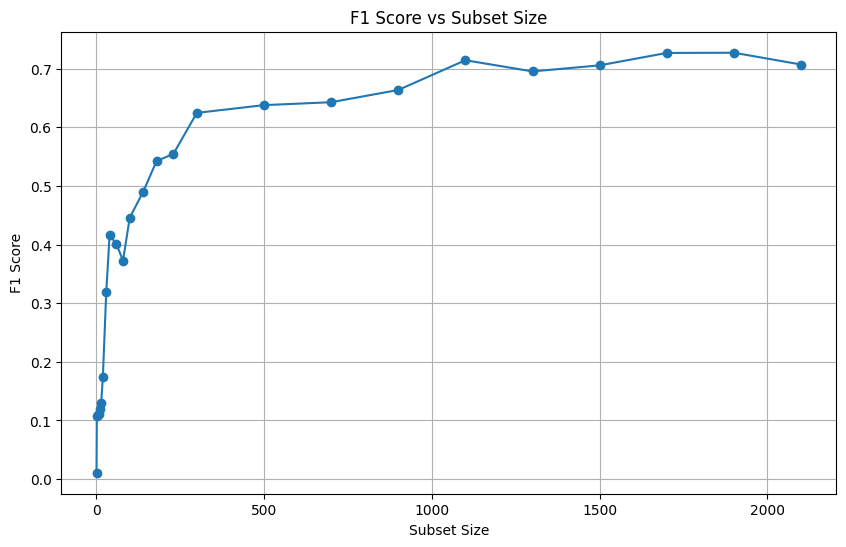

In [7]:
# Plotting f1_score over subset size
plt.figure(figsize=(10, 6))
plt.plot(noreportmetrics['subset_size'], noreportmetrics['f1_score'], marker='o')
plt.xlabel('Subset Size')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Subset Size')
plt.grid(True)
plt.show()

In [10]:

# Load the CSV files
metrics_small = pd.read_csv('metrics_small.csv')
metrics_large = pd.read_csv('metrics_large.csv')

# Combine the dataframes
combined_metrics = pd.concat([metrics_small, metrics_large], ignore_index=True)


# Save the combined dataframe to a new CSV file
output_path = 'data/metrics.csv'
combined_metrics.to_csv(output_path, index=False)

output_path


'data/metrics.csv'